<a href="https://colab.research.google.com/github/andreytsimbalov/Diplom/blob/main/Classifier_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

md = '/content/drive/My Drive/Colab Notebooks/Diplom/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sklearn.cluster as sc
import gensim
import random
import pandas as pd
import numpy as np
import time
import datetime
import pickle
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
main_tags_list = ['economy',
 'entertainment',
 'other',
 'science',
 'society',
 'sports',
 'technology']

main_tags_dict = {0: 'economy',
 1: 'entertainment',
 2: 'other',
 3: 'science',
 4: 'society',
 5: 'sports',
 6: 'technology'}

In [ ]:
# data = pd.read_pickle(md+'data/news_main_prepr_2020')
# label = np.unique(data.label)
# labels_list = label[1:]
# main_tags_list = [data[data.label == label].main_tag.iloc[0] for label in labels_list]
# del data
# main_tags_dict = dict(zip(labels_list, main_tags_list))
# main_tags_dict

In [ ]:
months = {
    'января':'01',
    'февраля':'02',
    'марта':'03',
    'апреля':'04',
    'мая':'05',
    'июня':'06',
    'июля':'07',
    'августа':'08',
    'сентября':'09',
    'октября':'10',
    'ноября':'11',
    'декабря':'12'
}
months_numbers = list(months.values())

In [ ]:
def take_from_model(model):
  vocab_m = np.array(list(model.wv.vocab))
  counts_m = np.array([model.wv.vocab[v].count for v in vocab_m])
  n=10 # Выводит первые n самых частотных слов
  counts_max_m = sorted(np.unique(sorted(counts_m,reverse=True)[:n]),reverse=True)
  freq_index = [j  for i in counts_max_m for j in np.where(counts_m == i)[0]]
  freq_m = [vocab_m[i] for i in freq_index]
  return vocab_m, counts_m, counts_max_m, freq_m

# Извлечение данных для обучения


In [ ]:
# надо нормально проработать индексы для W2v+tfidf в балансиворке и шафле!!!!

In [ ]:
# data = pd.read_pickle(md+'data/news_main_2020')
# data.head()

In [ ]:
def load_data_to_list_of_dict(path):
  # path on lemm/stem data
  # {"label": l,"text": t, }

  df  = pd.read_pickle(path)
  label = df.label.to_numpy()
  try:
    text = df.text.to_numpy()
  except:
    text = df.main_text.to_numpy()
    print('text = main_text')

  # return [{"id": i,"label": l,"text": t, } for i, l, t in zip(range(len(label)),label,text)]
  return [{"id": i,"label": l,"text": t, } for i, l, t in zip(range(len(label)),label,text) if l!=-1]

path = md + 'data/data_lemm'
path = md + 'data/news_main_2020'
# path = md + 'data/data_stem'
data_text = load_data_to_list_of_dict(path)
len(data_text), data_text[4]

text = main_text


(69955,
 {'id': 6,
  'label': 1,
  'text': 'Лоза отреагировал на критику концертов Пугачевой. Композитор Юрий Лоза в интервью РИА Новости Крым прокомментировал критику концертов Аллы Пугачевой, заявив, что у телезрителя должно быть право выбора. Ранее музыкальный критик Сергей Соседов признался, что не рад возвращению на сцену ряда исполнителей, приведя в пример Аллу Пугачеву, Софию Ротару, Николая Носкова. Он назвал их выступления "печальным зрелищем", подчеркнув, что примадонна "еле дышит, когда стоит на сцене". Лоза встал на защиту российских артистов, отметив, что "мир должен быть цветным". "Если люди хотят видеть этих артистов, они должны их видеть. А те, кто не хотят – могут на них не смотреть. Для этого должно быть много разных телепередач, чтобы каждый житель страны мог выбрать желаемую", – рассказал композитор. Композитор добавил, что возраст исполнителя не имеет значения. По его мнению, важно, в какой форме находится артист. "Какая разница, сколько Мирей Матье? За границей чу

In [ ]:
def data_tr_ts_shaffle(data, koeff = 0.2):
  # разбиение всего датасета на 
  #   тренировосный и тестовый с
  #   коеффициентом koeff

  
  data = [d for d in data if d['label']!=-1]

  random.seed(42)
  random.shuffle(data)

  data_tr_idx=[]
  data_ts_idx=[]

  data_tr=[]
  data_ts=[]

  tags = [d["label"] for d in data]
  mtv = np.zeros(len(main_tags_list))
  for d in data:
    mtv[d['label']]+=1
  # mtv = list(main_tags_dict.values())
  mtv_ts = np.zeros(len(mtv))
  for i, d in enumerate(data):
    now_tag = d['label']
    if mtv_ts[now_tag] < koeff * mtv[now_tag]:
      data_ts_idx.extend([i])
    else:
      data_tr_idx.extend([i])

    mtv_ts[now_tag]+=1

  random.shuffle(data_tr_idx)
  random.shuffle(data_ts_idx)

  data_tr = [data[i] for i in data_tr_idx]
  data_ts = [data[i] for i in data_ts_idx]

  data_tr_idx = [data[i]['id'] for i in data_tr_idx]
  data_ts_idx = [data[i]['id'] for i in data_ts_idx]

  return data_tr, data_tr_idx, data_ts, data_ts_idx

# data_train, data_test = data_tr_ts_shaffle(data_text_bal_tfidf, 0.2) 
# len(data_train), len(data_test) 

In [ ]:
def balancing_classes_data(X, more_less = True, koeff_len = 0.5, return_indexes = False):
  # more_less = True -> баленсировка вверх
  # more_less = False -> баленсировка вниз

  
  X = [d for d in X if d['label']!=-1]

  labels = [news["label"] for news in X]
  un = np.unique(labels)
  un_tags_dict = dict(zip(un, np.zeros(len(un))))
  for i in X:
    un_tags_dict[i["label"]]+=1

  if more_less:
    normal_un_len = 0
    for u in un:
      if un_tags_dict[u]>normal_un_len:
        normal_un_len = un_tags_dict[u]
  else:
    normal_un_len =  un_tags_dict[un[0]]
    for u in un:
      if un_tags_dict[u]<normal_un_len:
        normal_un_len = un_tags_dict[u]

  
  new_dtr=[]
  new_dtr_indexes=[]

  if more_less:
    normal_un_len = normal_un_len * koeff_len
    for x_i in X:
      # new_dtr+=[x_i]
      new_dtr_indexes+=[x_i['id']]
      if un_tags_dict[x_i["label"]]<normal_un_len:
        for _ in range(int(normal_un_len//un_tags_dict[x_i["label"]])):
          # new_dtr+=[x_i]
          new_dtr_indexes+=[x_i['id']]

  else:
    normal_un_len = normal_un_len / koeff_len
    un_tags_count_less = dict(zip(un, np.zeros(len(un))))
    for i, x_i in enumerate(X):
      if un_tags_count_less[x_i["label"]]<normal_un_len:
        un_tags_count_less[x_i["label"]]+=1
        # new_dtr+=[x_i]
        new_dtr_indexes+=[i]
  print(f'normal_un_len: {normal_un_len}')
  
  # random.shuffle(new_dtr)
  random.shuffle(new_dtr_indexes)

  new_dtr = [X[i] for i in new_dtr_indexes]
  new_dtr_indexes = [X[i]['id'] for i in new_dtr_indexes]

  return new_dtr, new_dtr_indexes

# data_text_bal_tfidf = balancing_classes_data(data_text_tfidf, False, 0.7)
# len(data_text_bal_tfidf)

In [ ]:
data_train, data_train_idx, data_test, data_test_idx = data_tr_ts_shaffle(data_text, 0.2) 

more_less = False # True -> Up; False -> Down
data_train, data_train_idx = balancing_classes_data(data_train, more_less, 1)
data_test, data_test_idx = balancing_classes_data(data_test, more_less, 1)
print(len(data_train), len(data_test))

X_train_text = [d['text'] for d in data_train]
X_test_text = [d['text'] for d in data_test]

y_train = [d['label'] for d in data_train]
y_test = [d['label'] for d in data_test]
data_train[:5]

normal_un_len: 3876.0
normal_un_len: 969.0
27132 6783


[{'id': 94022,
  'label': 1,
  'text': 'Ефремову предложили сдать анализы из-за запаха алкоголя в суде. Бывший адвокат Михаила Ефремова Эльман Пашаев предложил организовать сдачу анализов актером, так как подсудимого обвинили в запахе алкоголя на заседаниях. Об этом в пятницу, 21 августа, сообщает ТАСС. «Это бессовестный человек говорит. Ефремов не употребляет», — заявил Пашаев в ответ на слова о том, что от артиста пахнет спиртным. Ранее Ефремов заявил в суде, что отказывается от услуг Пашаева и его партнера Елизаветы Шаргородской. Затем адвокат попал на видео, запечатлевшее его удивление решением артиста. Вечером 8 июня Михаил Ефремов в состоянии алкогольного опьянения устроил смертельную аварию в центре Москвы. Автомобиль актера вылетел на встречную полосу и столкнулся с фургоном, водитель которого, Сергей Захаров, скончался в больнице. Ефремов заявил, что ничего не помнит о произошедшем. '},
 {'id': 14143,
  'label': 4,
  'text': 'На воров в законе Пухлого и Пузыря завели дела о ли

In [ ]:
max_sent_len = 0
for text_i in tqdm([d['text'] for d in data_text]):
  now_len = len(text_i.split())
  max_sent_len = max(max_sent_len, now_len)
max_sent_len

7152

# w2v классификация модели

In [ ]:
X_vectors = pickle.load(open(md+"models/w2v_tfidf_vector_data.pickle", "rb"))
# X_vectors_train = pickle.load(open(md+"models/w2v_tfidf_train_data_down.pickle", "rb"))
# X_vectors_test = pickle.load(open(md+"models/w2v_tfidf_test_data.pickle", "rb"))

In [ ]:
len(data_train_idx) == len(X_vectors_train)

In [ ]:
X_train = [X_vectors[i] for i in data_train_idx]
X_test = [X_vectors[i] for i in data_test_idx]
len(X_train), len(X_test)

(27132, 6783)

In [ ]:
w2v = gensim.models.Word2Vec.load(md+"models/w2v_lemm_300.model")

In [ ]:
tfidf = pickle.load(open(md+"models/tfidf_lemm.pickle", "rb"))
tfidf_words = tfidf.get_feature_names()
tfidf_dict = dict(zip(tfidf_words, tfidf.idf_))

In [ ]:
# def get_w2v_similar_words(pos = "", neg = ""):
#     # pos = [rs.stem(i) for i in pos.split()]
#     # neg = [rs.stem(i) for i in neg.split()]
#     return w2v.wv.most_similar(positive=pos, negative = neg)

# get_w2v_similar_words('спорт', '')

In [ ]:
def word_embedding_w2v_with_tfidf(text, model):
  # векторизация слов в тексте с tfidf
  word_embedd = []
  for text_i in tqdm(text):
    we = np.zeros(model.wv.vector_size)
    count = 0
    for word in text_i.split():
      try:
      # if word in model.wv.vocab and word in tfidf_words:
        tfidf_koeff = tfidf_dict[word]
        we += model.wv[word] * tfidf_koeff
        # we = [we_i + wv * tfidf_koeff for we_i, wv in zip(we, model.wv[word])]
        count+=1
      except:
        pass
    if count!=0:
      we = we / count
    word_embedd.extend([we])
  return word_embedd

x_test_data = word_embedding_w2v_with_tfidf(X_train_text[:100], w2v)

In [ ]:
len(x_test_data[0])

300

In [ ]:
x_test_data

In [ ]:
X_train = word_embedding_w2v_with_tfidf(X_train_text, w2v)
X_test = word_embedding_w2v_with_tfidf(X_test_text, w2v)
len(X_train), len(X_test)

In [ ]:
len(X_train), len(X_test)

36564

In [ ]:
X_train[0]

In [ ]:
# del X_train
# del X_test

In [ ]:
pickle.dump(X_train, open(md+"models/w2v_tfidf_train_data_down.pickle", "wb"))
pickle.dump(X_test, open(md+"models/w2v_tfidf_test_data.pickle", "wb"))

In [ ]:
X_train = pickle.load(open(md+"models/w2v_tfidf_train_data_down.pickle", "rb"))
X_test = pickle.load(open(md+"models/w2v_tfidf_test_data.pickle", "rb"))

# d2v классификация модели

In [ ]:
d2v = gensim.models.Doc2Vec.load(md+"models/d2v_300.model")

In [ ]:
X_train = [d2v.infer_vector(text) for text in tqdm(X_train_text)]
X_test = [d2v.infer_vector(text) for text in tqdm(X_test_text)]

# ft классификация модели

In [ ]:
ft = gensim.models.FastText.load(md+"models/ft_lemm_300.model")

In [ ]:
X_train = [ft.wv[text] for text in tqdm(X_train_text)]
X_test = [ft.wv[text] for text in tqdm(X_test_text)]

In [ ]:
ft.wv['стул на окне']

array([-0.13938819,  0.13782135,  0.00818403, -0.056635  ,  0.14813697,
        0.20309918,  0.07544893, -0.03914022,  0.1029293 , -0.02570491,
       -0.15037747,  0.01061253,  0.42531228, -0.38926828, -0.1170243 ,
       -0.23653622, -0.29696915, -0.06454967,  0.14811797, -0.0894557 ,
       -0.01638108, -0.16436319,  0.00830548,  0.11698557,  0.11642069,
        0.1526308 ,  0.26587525,  0.1155118 ,  0.02721938, -0.05723517,
       -0.11691627, -0.28376487, -0.135189  ,  0.02886016,  0.00586162,
       -0.18568073, -0.15489799, -0.41902968,  0.20609982, -0.06677084,
       -0.05600274, -0.52296686,  0.06533867,  0.00815786, -0.0745108 ,
       -0.15224636,  0.05094982, -0.1275503 , -0.01461357,  0.08126971,
        0.14845829,  0.04142716,  0.05028716, -0.13945504,  0.28211328,
        0.0476862 ,  0.15682152,  0.14704819, -0.08211517,  0.02179574,
        0.19461097,  0.25559148, -0.07075904, -0.00532726, -0.26908037,
        0.06544256, -0.10655179,  0.07917219, -0.2080824 , -0.30

# tfidf классификация модели

In [ ]:
tfidf = pickle.load(open(md+"models/tfidf_lemm.pickle", "rb"))

In [ ]:
X_train = tfidf.transform(X_train_text)
X_test = tfidf.transform(X_test_text)
X_test.shape

(6783, 663344)

# glove классификация модели

In [ ]:
!pip install navec slovnet

     |████████████████████████████████| 51kB 3.5MB/s 


In [ ]:
import torch
from navec import Navec
from slovnet.model.emb import NavecEmbedding

In [ ]:
path = 'models/navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB
navec = Navec.load(md + path)  # ~1 sec, ~100MB RAM

In [ ]:
tfidf = pickle.load(open(md+"models/tfidf_lemm.pickle", "rb"))
tfidf_words = tfidf.get_feature_names()
tfidf_dict = dict(zip(tfidf_words, tfidf.idf_))

In [ ]:
# words = ['стол', 'стул', 'паровоз']
# ids = [navec.vocab[_] for _ in words]
# input = torch.tensor(ids)

# emb = NavecEmbedding(navec)
# emb(input)  # 3 x 300

In [ ]:
def word_embedding_glove_with_tfidf(text):
  # векторизация слов в тексте с tfidf
  word_embedd = []
  nav_emb = NavecEmbedding(navec)
  for text_i in tqdm(text):
    we = np.zeros(len(nav_emb(torch.tensor(0))))
    count = 0
    for word in text_i.split():
      try:
        tfidf_koeff = tfidf_dict[word]
        word_tensor_vec = nav_emb(torch.tensor(navec.vocab[word]))
        we += np.array(word_tensor_vec) * tfidf_koeff
        count+=1
      except:
        pass
    if count!=0:
      we = we / count
    word_embedd.extend([we])
  return word_embedd

x_test_data = word_embedding_glove_with_tfidf(X_train_text[:100])

/usr/local/lib/python3.7/dist-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  torch.from_numpy(navec.pq.indexes),


In [ ]:
len(x_test_data[0])

300

In [ ]:
x_test_data

In [ ]:
X_train = word_embedding_glove_with_tfidf(X_train_text)
X_test = word_embedding_glove_with_tfidf(X_test_text)

In [ ]:
len(X_train)

36564

In [ ]:
X_train[0]

In [ ]:
pickle.dump(X_train, open(md+"models/glove_tfidf_train_data_down.pickle", "wb"))
pickle.dump(X_test, open(md+"models/glove_tfidf_test_data.pickle", "wb"))

# LogisticRegression & LinearSVC

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score as cvs
from sklearn import metrics


In [ ]:
clf = LinearSVC(C = 0.6, random_state = 42)
%time clf.fit(X_train, y_train) # [:1000]
print(clf.score(X_test, y_test))
print(clf.score(X_train, y_train))

CPU times: user 1min 10s, sys: 24 ms, total: 1min 10s
Wall time: 1min 9s
0.8400412796697626
0.8569585729028454


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
clf = LogisticRegression(n_jobs=-1, random_state=42)#,class_weight='balanced'
%time clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.score(X_train, y_train))

CPU times: user 160 ms, sys: 339 ms, total: 500 ms
Wall time: 9.52 s
0.8366504496535456
0.8582117057349256


In [ ]:
%time cvs_res = cvs(clf, X_train, y_train, cv = 5,n_jobs=8)
print(cvs_res.mean())
print(cvs_res)

CPU times: user 19.6 s, sys: 1.21 s, total: 20.8 s
Wall time: 43.6 s
0.8452848723280175
[0.84329277 0.84042117 0.84301928 0.85833447 0.84135667]


In [ ]:
main_tags_dict

{0: 'economy',
 1: 'entertainment',
 2: 'other',
 3: 'science',
 4: 'society',
 5: 'sports',
 6: 'technology'}

In [ ]:
print(str(clf)[:20])
a = np.array(main_tags_list)
b = metrics.confusion_matrix(y_test,clf.predict(X_test))
pd.DataFrame(data=b,index = a,columns=a)

LogisticRegression(C


,economy,entertainment,other,science,society,sports,technology
economy,297,70,63,153,180,94,112
entertainment,80,304,67,93,154,201,70
other,146,107,243,121,91,111,150
science,132,95,90,387,82,63,120
society,163,88,28,40,396,177,77
sports,66,159,66,39,171,415,53
technology,139,125,161,140,98,85,221


In [ ]:

predicted_lr = clf.predict(X_test)
# predicted_lr_pr = clf.predict_proba(X_test_idf)
# maxes = np.max(predicted_lr_pr, axis=1)
# predicted_lr = np.where(maxes>0.45, predicted_lr, np.ones(len(predicted_lr))*10)
print(metrics.classification_report(predicted_lr, y_test))

              precision    recall  f1-score   support

           0       0.31      0.29      0.30      1023
           1       0.31      0.32      0.32       948
           2       0.25      0.34      0.29       718
           3       0.40      0.40      0.40       973
           4       0.41      0.34      0.37      1172
           5       0.43      0.36      0.39      1146
           6       0.23      0.28      0.25       803

    accuracy                           0.33      6783
   macro avg       0.33      0.33      0.33      6783
weighted avg       0.34      0.33      0.34      6783



# Обработка тегов

In [ ]:
data = pd.read_pickle(md+'data/news_main_2020')

In [ ]:
# # def parse_lenta(input_file, output_file, use_preprocess=True):
# parts = {
#     "society": 0.02,
#     "economy": 0.02,
#     "sports": 0.02,
#     "technology": 0.02,
#     "science": 0.02,
#     "other": 0.02,
#     "entertainment": 0.02
# }
# topics_mapping = {
#     "Экономика": "economy",
#     "Спорт": "sports",
#     "Силовые структуры": "society",
#     "Бизнес": "economy",
#     "Культпросвет": "entertainment",
#     ("Наука и техника", "Игры"): "entertainment",
#     ("Наука и техника", "Наука"): "science",
#     ("Наука и техника", "Космос"): "science",
#     ("Наука и техника", "Жизнь"): "science",
#     ("Наука и техника", "История"): "science",
#     ("Наука и техника", "Оружие"): "society",
#     ("Наука и техника", "Гаджеты"): "technology",
#     ("Наука и техника", "Софт"): "technology",
#     ("Наука и техника", "Техника"): "technology",
#     ("Мир", "Общество"): "society",
#     ("Мир", "Политика"): "society",
#     ("Мир", "Происшествия"): "society",
#     ("Мир", "Конфликты"): "society",
#     ("Мир", "Преступность"): "society",
#     ("Россия", "Политика"): "society",
#     ("Россия", "Общество"): "society",
#     ("Россия", "Происшествия"): "society",
#     ("Интернет и СМИ", "Мемы"): "technology",
#     ("Интернет и СМИ", "Киберпреступность"): "technology",
#     ("Интернет и СМИ", "Интернет"): "technology",
#     ("Интернет и СМИ", "Вирусные ролики"): "technology",
#     ("Ценности", "Стиль"): "other",
#     ("Ценности", "Явления"): "other",
#     ("Ценности", "Внешний вид"): "other",
#     ("Ценности", "Движение"): "technology",
#     ("Из жизни", "Происшествия"): "society",
#     ("Путешествия", "Происшествия"): "society",
# }

In [ ]:
tags = [] 
for _ in  data.tags:
    tags+=[_]

tags = np.array(tags)
all_tags = [j for t in tags for j in t]
uniq_tags = np.unique(all_tags) #1183
len(uniq_tags)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


12273

In [ ]:
tagsu = dict(zip(uniq_tags, np.zeros(len(uniq_tags)).astype('int64')))
for i in all_tags:
    tagsu[i]+=1
    
utu = np.array([tagsu[i] for i in uniq_tags])# utu - частота тегов uniq_tags
uniq_tags[np.where(utu >3000)]

array(['В мире', 'Здоровье - Общество', 'Коронавирус COVID-19',
       'Коронавирус в России', 'Москва', 'Общество', 'Происшествия',
       'Распространение коронавируса', 'Россия', 'США'], dtype='<U178')

In [ ]:
main_tags = set(['В мире', 'Политика', 'Происшествия', 
                 'Общество', 'Экономика', 'Наука',
                 'Вокруг спорта', 'Культура']) # ,'Коронавирус COVID-19', 'Туризм'

In [ ]:
m_t_joint = np.where(np.array([not main_tags.isdisjoint(tag) for tag in tags])==True)[0]
m_t_joint.shape

(36457,)

In [ ]:
main_tags_list = sorted(list(main_tags))

mt_indexer =  dict(zip(main_tags_list, range(len(main_tags_list))))
sport_index = mt_indexer['Вокруг спорта']
sport_tags = ['UFC','Футбол','Хоккей',
              'Хабиб Нурмагомедов','Фигурное катание','Российская премьер-лига',
              'Биатлон','Единоборства','Зенит']
for st in sport_tags:
  mt_indexer[st] = sport_index

mt_indexer_keys = list(mt_indexer.keys())

main_tags_dict = dict(zip(main_tags_list,np.zeros(len(main_tags_list))))

main_tags_dict_reverse = dict(zip(range(len(main_tags_list)), main_tags_list))

main_tags_id_in_data = [-1 for _ in range(len(tags))]

clear_tags_index = []
clear_tags_value = []
external_counter = 0 # счетчик пересекающихся тегов
for t_i, t in enumerate(tags):
  # counter=0
  # now_tag=-1
  # for mtl_i, mtl in enumerate(main_tags_list):
  #   if mtl in t:
  #     main_tags_dict[mtl]+=1
  #     counter+=1
  #     now_tag = mtl_i
  # if counter>1:
  #   external_counter+=1
  # elif counter==1:
  #   clear_tags_index.extend([t_i])
  #   clear_tags_value.extend([now_tag])

  asd = 0
  now_tag = -1
  for mtik in mt_indexer_keys:
    if mtik in t:
      if now_tag ==-1:
        now_tag = mt_indexer[mtik]
      elif  mt_indexer[mtik]!=now_tag:
        now_tag=-1
        external_counter+=1
        break
  main_tags_id_in_data[t_i] = now_tag

  if now_tag!=-1:
    main_tags_dict[main_tags_dict_reverse[now_tag]]+=1
    clear_tags_index.extend([t_i])
    clear_tags_value.extend([now_tag])

main_tags_id_in_data = np.array(main_tags_id_in_data)
data['main_tag'] = main_tags_id_in_data

print(external_counter)
main_tags_dict

1354


{'В мире': 13518.0,
 'Вокруг спорта': 2885.0,
 'Культура': 1445.0,
 'Наука': 1077.0,
 'Общество': 9920.0,
 'Политика': 981.0,
 'Происшествия': 5178.0,
 'Экономика': 2527.0}

In [ ]:
qwe = main_tags_id_in_data>0
qwe.sum()

24013

In [ ]:
len(clear_tags_index)==len(clear_tags_value), len(clear_tags_index)

(True, 37531)

<BarContainer object of 8 artists>

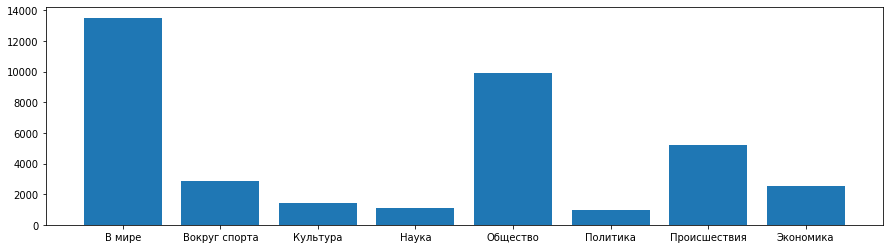

In [ ]:
keys = main_tags_dict.keys()
values = main_tags_dict.values()

plt.figure(figsize=(15, 4))
plt.bar(keys, values)

In [ ]:
np.sum(list(main_tags_dict.values())), len(tags[m_t_joint])

(37531.0, 36457)

In [ ]:
m_t = np.array([main_tags.isdisjoint(tag) for tag in tags])
non_normal_tags = tags[np.where(m_t==True)] # теги, не входящие в main_tags
all_non_normal_tags=[]
for nnt in non_normal_tags:
  all_non_normal_tags += nnt
all_non_normal_tags_un = np.unique(all_non_normal_tags)
len(non_normal_tags)

9472

In [ ]:
nntu = dict(zip(all_non_normal_tags_un, np.zeros(len(all_non_normal_tags_un)).astype('int64')))
for i in all_non_normal_tags:
    nntu[i]+=1

nntu_keys = np.array(list(nntu.keys()))
nntu_vals = np.array(list(nntu.values()))
# utu = np.array([tagsu[i] for i in uniq_tags])# utu - частота тегов uniq_tags
nntu_keys[np.where(nntu_vals > 100)]

array(['UFC', 'Авторы', 'Александра Трусова', 'Безопасность',
       'Белоруссия', 'Биатлон', 'ВОЗ', 'Великобритания', 'Владимир Путин',
       'Германия', 'Госдума РФ', 'Дональд Трамп', 'Евгений Плющенко',
       'Единоборства', 'Жилье', 'ЗОЖ', 'Здоровье', 'Здоровье - Общество',
       'Зенит', 'Знаменитости', 'Италия', 'Китай', 'Коронавирус COVID-19',
       'Коронавирус в России', 'Коронавирусы', 'Космос - РИА Наука',
       'Международная космическая станция (МКС)', 'Мнение - Авторы',
       'Москва', 'Московская область (Подмосковье)',
       'Новое оружие России', 'Новости - Туризм', 'Открытия - РИА Наука',
       'Питание', 'Распространение коронавируса',
       'Религия и мировоззрение', 'Республика Крым', 'Роскосмос',
       'Российская премьер-лига', 'Россия', 'США', 'Сергей Собянин',
       'Смешанные боевые искусства (ММА)', 'Сочи', 'Спорт', 'Технологии',
       'Туризм', 'Турция', 'Украина', 'ФК Спартак (Москва)',
       'Федеральная служба по надзору в сфере защиты прав п

In [ ]:
main_tags_dict

{'В мире': 13518.0,
 'Вокруг спорта': 2885.0,
 'Культура': 1445.0,
 'Наука': 1077.0,
 'Общество': 9920.0,
 'Политика': 981.0,
 'Происшествия': 5178.0,
 'Экономика': 2527.0}

In [ ]:
annt_count = np.array([tagsu[_] for _ in all_non_normal_tags_un])
all_non_normal_tags_un[np.where(annt_count >1000)]

array(['Азербайджан', 'Александр Лукашенко', 'Армения', 'Белоруссия',
       'ВОЗ', 'Владимир Путин', 'Германия', 'Госдума РФ', 'Дональд Трамп',
       'Здоровье', 'Здоровье - Общество', 'Китай', 'Коронавирус COVID-19',
       'Коронавирус в России', 'Коронавирусы', 'Москва',
       'Распространение коронавируса', 'Россия', 'США',
       'Ситуация в Нагорном Карабахе',
       'Следственный комитет России (СК РФ)', 'Туризм', 'Украина',
       'Федеральная служба по надзору в сфере защиты прав потребителей и благополучия человека (Роспотребнадзор)',
       'Футбол', 'Шоу-бизнес'], dtype='<U125')

# обучение распознаванию тегов

In [ ]:
w2v_tags = gensim.models.Word2Vec.load(md+'models/w2v_tags_2020.model')

In [ ]:
import string
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import RussianStemmer 
rs = RussianStemmer()

In [ ]:
import nltk
nltk.download()

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что','однако', 
                   'это', 'так', 'вот', 'быть','уже', 'как', 'в','из-за', '—', '–', 'к', 'на', '...','»', '«','``',"''"])
stop_words.extend(list(string.punctuation))

def tokenize_sent2words_ru(sentence):
    sentence=sentence.lower()
    tokens = word_tokenize(sentence, 'russian')
    tokens = [rs.stem(i) for i in tokens if (i not in stop_words)]
    for i in range(len(tokens)): 
        if tokens[i].isdigit():
            tokens[i] = 'число'
    return tokens


def tokenize_text2words_ru(text):
    res = []
    for sent in sent_tokenize(text, 'russian'):
        res+= tokenize_sent2words_ru(sent)
#     res = [tokenize_sent2words_ru(sent) for sent in sent_tokenize(text, 'russian')]
    return res

In [ ]:
# tokenize_text2words_ru(data['main_text'][0])+tags[0]

In [ ]:
data_train_for_tags = [tokenize_text2words_ru(main_text)+tags[i] for i, main_text in tqdm(enumerate(data['main_text']))]

In [ ]:
w2v_tags = gensim.models.Word2Vec(tqdm(data_train_for_tags), workers=8, iter=20, min_count=10)
w2v_tags.save(md+'data/w2v_tags_2020.model')

In [ ]:
w2v_tags.similarity(main_tags_list[0], main_tags_list[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


1.0

In [ ]:
nnt_change=[]
for nnt in non_normal_tags:
  vars = dict(zip(main_tags_list, np.zeros(len(main_tags_list))))
  for t in nnt:
    for mtl in main_tags_list:
      try:
        now_sim = w2v_tags.similarity(t, mtl)
        # vars[mtl]=max(vars[mtl],now_sim)
        vars[mtl]+=now_sim
        # if now_sim==1:
        #   vars[mtl]+=10
      except:
        # print(t+' '+ mtl +' не в словаре w2v')
        qwe=1
  nnt_change+=[[main_tags_list[np.argmax(list(vars.values()))], nnt ]]
# nnt_change[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


In [ ]:
nnt_change[10:20]

In [ ]:
for i in main_tags_list:
  print('* '+i)# , end='___: '
  print([_ for _ in w2v_tags.most_similar(i)])
  

* В мире
[('Протесты', 0.6304927468299866), ('Бритни Спирс', 0.6057103872299194), ('Стамбул', 0.595970630645752), ('Евросовет', 0.5915004014968872), ('Баден-Вюртемберг', 0.5864671468734741), ('Видео', 0.5855875611305237), ('Северная Америка', 0.5839543342590332), ('Токио', 0.5822155475616455), ('Центральное разведывательное управление', 0.5818876028060913), ('Бразилия', 0.5816608667373657)]
* Вокруг спорта
[('Легкая атлетика', 0.8596296906471252), ('Художественная гимнастика', 0.8319743275642395), ('Спорт в условиях пандемии коронавируса', 0.828439474105835), ('Плавание', 0.8175042867660522), ('Дмитрий Губерниев', 0.8115640878677368), ('Теннис', 0.8030461668968201), ('Борьба', 0.8008598685264587), ('Олимпийские игры', 0.7972670197486877), ('Материалы РИА Спорт', 0.7943527102470398), ('Sport Stories', 0.7929099202156067)]
* Культура
[('Шоубиз', 0.7915530800819397), ('Шоу-бизнес', 0.7580008506774902), ('Новости культуры', 0.7524923086166382), ('Музыка', 0.7449674606323242), ('Александр Г

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


# Графики популярных тегов

In [ ]:
# grdata = data_1.groupby('time').agg({'views':['sum','min','max','mean']})
# # grdata = data_1.groupby(pd.Grouper(key="dt", freq="3D")).agg({'views':['sum','min','max','mean']})
# grdata

In [ ]:
data = pd.read_pickle(md+'data/news_main_2020')

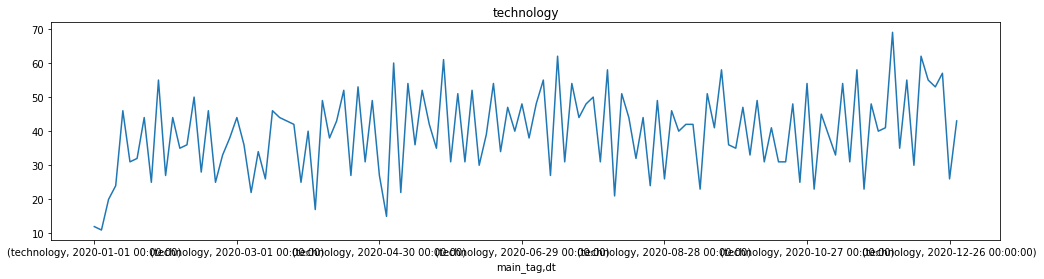

In [ ]:
# grdata = data.groupby([pd.Grouper(key='dt', freq="3D"), 'label']).count()
i = 6
grdata = data[data.main_tag == main_tags_list[i]].groupby(['main_tag', pd.Grouper(key='dt', freq="3D")]).agg({'main_tag':['count']})
plt.figure(figsize=(17, 4))
plt.title(main_tags_list[i])
grdata['main_tag']['count'].plot()

In [ ]:
# np.array(data['views']==None).sum()

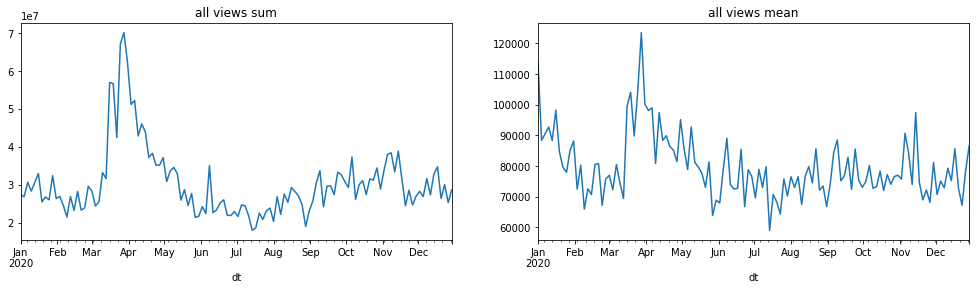

In [ ]:
plt.figure(figsize=(17, 4))
plt.subplot(1, 2, 1)
plt.title('all views sum')
grdata['views']['sum'].plot()
plt.subplot(1, 2, 2)
plt.title('all views mean')
grdata['views']['mean'].plot()

# Графики разных тегов

In [ ]:
def draw_plot_with_polyfit(now_grtd):
  x = np.arange(len(now_grtd))

  polif = np.polyfit(x, now_grtd.to_numpy(), 20) # grtd['views']['mean'].index
  f = np.poly1d(polif)

  y = f(x)
  # plt.figure(figsize=(15, 4))
  # plt.subplot(2, 1, 1)
  plt.plot(now_grtd.index,y)
  # plt.subplot(2, 1, 2)
  plt.plot(now_grtd)

Вокруг спорта


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RankWarning: Polyfit may be poorly conditioned
  app.launch_new_instance()


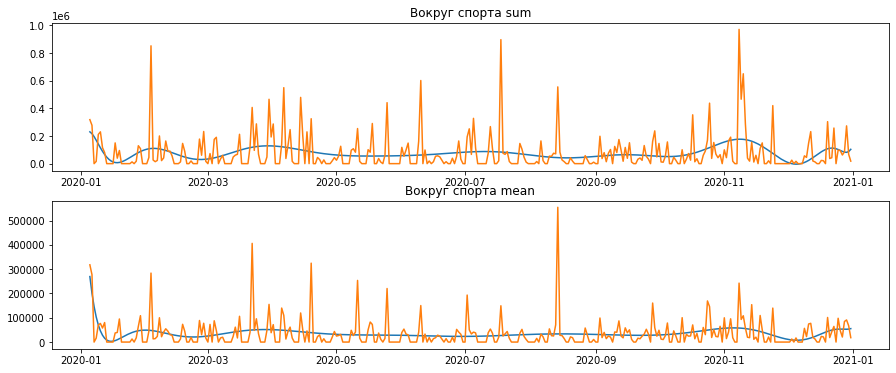

In [ ]:
now_tag_on_plot = main_tags_list[1]
print(now_tag_on_plot)
td = data.iloc[np.where([now_tag_on_plot in t for t in tags])[0]]
grtd = td.groupby(pd.Grouper(key="dt", freq="D")).agg({'views':['sum','min','max','mean']})
grtd = grtd.fillna(0)
# grtd['views']['sum'] = np.nan_to_num(grtd['views']['sum'])
# grtd['views']['mean'] = np.nan_to_num(grtd['views']['mean'])

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.title(f'{now_tag_on_plot} sum')
draw_plot_with_polyfit(grtd['views']['sum'])
# plt.plot(grtd['views']['sum'])
plt.subplot(2, 1, 2)
plt.title(f'{now_tag_on_plot} mean')
draw_plot_with_polyfit(grtd['views']['mean'])
# plt.plot(grtd['views']['mean'])
# grtd['views']['sum'].plot()

# Keras lesson

https://realpython.com/python-keras-text-classification/

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
from keras.utils import np_utils
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_tr = np_utils.to_categorical(encoded_Y)
encoded_Y_ts = encoder.fit_transform(y_test)
y_ts = np_utils.to_categorical(encoded_Y_ts)
y_tr.shape

(27132, 7)

In [ ]:
y_tr[-1], y_ts[-1]

(array([0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [ ]:
# for ...
x_tr = X_train
x_ts = X_test
input_dim = len(x_tr[0])

In [ ]:
# for w2v+tfidf glove+tfidf d2v ft 
x_tr = np.array(X_train).astype('float16')
x_ts = np.array(X_test).astype('float16')
input_dim = len(x_tr[0])

In [ ]:
# for thidf
x_tr = X_train.astype('float16')
x_ts = X_test.astype('float16')
input_dim = x_tr.shape[1]

In [ ]:
x_tr[0]

In [ ]:
x_tr = X_train_idf.toarray()
x_ts = X_test_idf.toarray()

In [ ]:
x_tr.shape

(36564, 300)

In [ ]:
len(x_tr[0])

300

In [ ]:
from keras.models import Sequential
from keras import layers

# input_dim = x_tr.shape[1]  # for thidf
# input_dim = len(x_tr[0])  # Number of features
# input_dim = 36564

# model = Sequential()
# model.add(layers.Embedding(input_dim=10000, 
#                            output_dim=32, 
#                            input_length=32))
# model.add(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))

model = Sequential()
model.add(layers.Dense(32, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(main_tags_list), activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# categorical_crossentropy
# binary_crossentropy
# model.summary()

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
# history = model.fit(x_tr, y_tr, epochs=2)

In [ ]:
history = model.fit(x_tr, y_tr,
                    epochs=15,
                    # verbose=1,
                    # batch_size=10,
                    # validation_split = 0.2
                    validation_data=(x_ts,y_ts)
                    )
# validation_data=(X_test_idf, y_test)

                    # validation_data=(x_ts,y_ts)

Epoch 1/15
848/848 [==============================] - 4s 4ms/step - loss: 1.0079 - accuracy: 0.6388 - val_loss: 0.5283 - val_accuracy: 0.8221
Epoch 2/15
848/848 [==============================] - 3s 4ms/step - loss: 0.5609 - accuracy: 0.8104 - val_loss: 0.4853 - val_accuracy: 0.8341
Epoch 3/15
848/848 [==============================] - 3s 3ms/step - loss: 0.5150 - accuracy: 0.8252 - val_loss: 0.4692 - val_accuracy: 0.8399
Epoch 4/15
848/848 [==============================] - 3s 4ms/step - loss: 0.4887 - accuracy: 0.8359 - val_loss: 0.4534 - val_accuracy: 0.8420
Epoch 5/15
848/848 [==============================] - 3s 3ms/step - loss: 0.4640 - accuracy: 0.8443 - val_loss: 0.4514 - val_accuracy: 0.8471
Epoch 6/15
848/848 [==============================] - 3s 3ms/step - loss: 0.4560 - accuracy: 0.8435 - val_loss: 0.4430 - val_accuracy: 0.8492
Epoch 7/15
848/848 [==============================] - 3s 3ms/step - loss: 0.4412 - accuracy: 0.8517 - val_loss: 0.4405 - val_accuracy: 0.8492
Epoch 

In [ ]:
loss, accuracy = model.evaluate(x_ts, y_ts, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_tr, y_tr, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Testing Accuracy:  0.8548
Training Accuracy: 0.8868


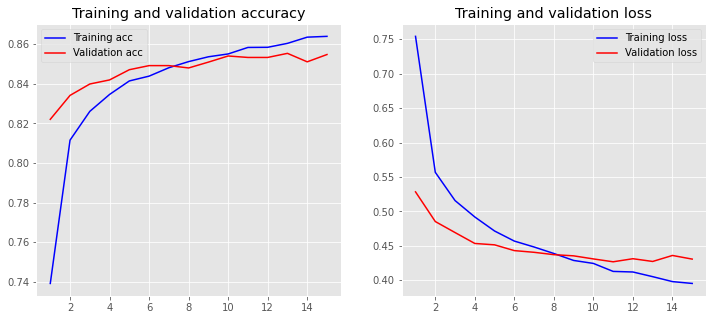

In [ ]:
plot_history(history)

# Подготовка данных Bert

In [ ]:
import gc
df = pd.read_pickle(md+'data/news_main_prepr_2020')
data_lists = []

# for i,t,l in tqdm(zip(df.index, df['lemm_text'], df['label'])):
#   data_lists.append({'id' : , 'text' : t, 'label' : l})
for i,t,l in tqdm(zip(df.index, df['lemm_text'], df['label'])):
  data_lists.append({'id' : i, 'text' : t, 'label' : l})

# print(getsizeof(df))
del df
gc.collect()

11

In [ ]:
data_train, data_train_idx, data_test, data_test_idx = data_tr_ts_shaffle(data_lists, 0.2) 

more_less = False # True -> Up; False -> Down
data_train, data_train_idx = balancing_classes_data(data_train, more_less, 1)
data_test, data_test_idx = balancing_classes_data(data_test, more_less, 1)
print(len(data_train), len(data_test))

# X_train_text = [d['text'] for d in data_train]
# X_test_text = [d['text'] for d in data_test]

# y_train = [d['label'] for d in data_train]
# y_test = [d['label'] for d in data_test]
# data_train[:5]
# len(data_train)

3876.0
969.0
27132 6783


In [ ]:
def sent_labeling(data):
  res = []
  for d in tqdm(data):
    for t_i in d['text']:
      text = ''
      for tl_i in t_i:
        text+=' '+tl_i
      res.append({'label': d['label'], 'text': text})
  return res

In [ ]:
data_train = sent_labeling(data_train)
data_test = sent_labeling(data_test)
len(data_train), len(data_test)

(379940, 96167)

In [ ]:
X_train_text = [d['text'] for d in data_train]
X_test_text = [d['text'] for d in data_test]

y_train = [d['label'] for d in data_train]
y_test = [d['label'] for d in data_test]

In [ ]:
del data_train
del data_test
del data_lists
del data_train_idx
del data_test_idx
gc.collect()

544220

In [ ]:
gc.collect()

239

In [ ]:
# max_sent_len = 0
# for text_i in tqdm(X_train_text):
#   now_len = len(text_i.split())
#   max_sent_len = max(max_sent_len, now_len)
# max_sent_len

135

# Bert tests

https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d

https://atheros.ai/blog/text-classification-with-transformers-in-tensorflow-2

https://colab.research.google.com/drive/1934Mm2cwSSfT5bvi78-AExAl-hSfxCbq

https://stackoverflow.com/questions/61000500/tensorflow-keras-bert-multiclass-text-classification-accuracy

https://towardsdatascience.com/multi-label-multi-class-text-classification-with-bert-transformer-and-keras-c6355eccb63a



In [ ]:
# without tokenazer

!pip install transformers

from transformers import TFBertForSequenceClassification
import tensorflow as tf

num_classes = len(main_tags_list)
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',num_labels=num_classes)
# bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

     |████████████████████████████████| 2.1MB 17.4MB/s 
     |████████████████████████████████| 3.3MB 37.5MB/s 
     |████████████████████████████████| 901kB 56.9MB/s 


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# with tokenazer

!pip install transformers

from transformers import *
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import tensorflow as tf

num_classes = len(main_tags_list)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased", do_lower_case = True)
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',num_labels=num_classes)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# Found GPU at: /device:GPU:0

Found GPU at: /device:GPU:0


## tokenizer

In [ ]:
# !pip install transformers

# import transformers as ppb


# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
# model_bert = model_class.from_pretrained(pretrained_weights)


# from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification


In [ ]:
# from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# num_classes = len(main_tags_list)
# bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# bert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased',num_labels=num_classes)

In [ ]:
max_len = 0
X_train_text

In [ ]:
sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
# sent= 'how to train '
sent = X_train_text[0]
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['о', '##прос', 'пока', '##за', '##ть', 'вы', '##сокий', 'до', '##вер', '##ие', 'мир', 'р', '##ф', 'со', '##здат', '##ель', 'ва', '##к', '##цина', 'число']


In [ ]:
tokenized_sequence= bert_tokenizer.encode_plus(sent, \
                                               add_special_tokens = True, \
                                               max_length =10, \
                                               pad_to_max_length = True,
return_attention_mask = True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
tokenized_sequence

{'input_ids': [101, 555, 99842, 45899, 13594, 11258, 96195, 71912, 10344, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:

bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] опрос показать высокий до [SEP]'

In [ ]:
max_sent_len

3705

In [ ]:
def prepare_text_for_bert(data_text, max_len = 512):
  max_len = min(max_len, 512)
  input_ids=[]
  attention_masks=[]
  for dt in tqdm(data_text):
      # sent = ''
      # for d in dt.split()[:max_len]:
      #     sent+=' '+d
      sent = dt
      bert_inp=bert_tokenizer.encode_plus(sent, \
                                          add_special_tokens = True,\
                                          max_length =max_len,\
                                          # padding = True,\
                                          pad_to_max_length = True,
                                          return_attention_mask = True)
      input_ids.append(bert_inp['input_ids'])
      attention_masks.append(bert_inp['attention_mask'])

  input_ids=np.asarray(input_ids)
  attention_masks=np.asarray(attention_masks)
  return input_ids, attention_masks

# qwe = prepare_text_for_bert(X_train_text[:5])
# len(qwe[0][0])
max_len = 512

In [ ]:
test_ids, test_mask = prepare_text_for_bert(X_test_text, max_len)
del X_test_text
len(test_ids[0]), len(test_mask[0]), len(test_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(512, 512, 6783)

In [ ]:
train_ids, train_mask = prepare_text_for_bert(X_train_text,max_len)
del X_train_text
len(train_ids[0]), len(train_mask[0]), len(train_mask)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(512, 512, 27132)

In [ ]:
max_len = 0
for text_i in tqdm(test_mask):
# for text_i in tqdm(train_mask):
  now_len = np.sum(text_i)
  max_len = max(max_len, now_len)
max_len

512

In [ ]:
max_len = 0
# for text_i in tqdm(test_mask):
for text_i in tqdm(train_mask):
  now_len = np.sum(text_i)
  max_len = max(max_len, now_len)
max_len

512

In [ ]:
# del X_test_text
# del X_train_text

In [ ]:
gc.collect()

0

In [ ]:
#_without_prepr
pickle.dump(test_ids, open(md+"data/bert_tokens/test_ids_down_1_joint_512_without_prepr.pickle", "wb"))
pickle.dump(test_mask, open(md+"data/bert_tokens/test_mask_down_1_joint_512_without_prepr.pickle", "wb"))
pickle.dump(train_ids, open(md+"data/bert_tokens/train_ids_down_1_joint_512_without_prepr.pickle", "wb"))
pickle.dump(train_mask, open(md+"data/bert_tokens/train_mask_down_1_joint_512_without_prepr.pickle", "wb"))

In [ ]:
pickle.dump(y_test, open(md+"data/bert_tokens/y_test_down_1_joint_512_without_prepr.pickle", "wb"))
pickle.dump(y_train, open(md+"data/bert_tokens/y_train_down_1_joint_512_without_prepr.pickle", "wb"))

In [ ]:
pickle.dump(test_ids, open(md+"data/bert_tokens/test_ids_down_1_joint_512.pickle", "wb"))
pickle.dump(test_mask, open(md+"data/bert_tokens/test_mask_down_1_joint_512.pickle", "wb"))
pickle.dump(train_ids, open(md+"data/bert_tokens/train_ids_down_1_joint_512.pickle", "wb"))
pickle.dump(train_mask, open(md+"data/bert_tokens/train_mask_down_1_joint_512.pickle", "wb"))

In [ ]:
pickle.dump(y_test, open(md+"data/bert_tokens/y_test_down_1_joint_512.pickle", "wb"))
pickle.dump(y_train, open(md+"data/bert_tokens/y_train_down_1_joint_512.pickle", "wb"))

## train_prepare

In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [ ]:
def tensor_encoder(input_ids_list, attention_mask_list, label_list, top_len = -1):
  token_type_ids_list = [[0]*len(input_ids_list[0])]*len(input_ids_list)
  # print(token_type_ids_list)
  # if len(label_list[0])==1:
  #   label_list = [[l] for l in label_list]
  # print(label_list)
  if top_len==-1:
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)
  else:
    return tf.data.Dataset.from_tensor_slices((input_ids_list[:top_len], attention_mask_list[:top_len], token_type_ids_list[:top_len], label_list[:top_len])).map(map_example_to_dict)


In [ ]:
test_ids = pickle.load(open(md+"data/bert_tokens/test_ids_down_1_joint_512.pickle", "rb"))
test_mask = pickle.load(open(md+"data/bert_tokens/test_mask_down_1_joint_512.pickle", "rb"))
train_ids = pickle.load(open(md+"data/bert_tokens/train_ids_down_1_joint_512.pickle", "rb"))
train_mask = pickle.load(open(md+"data/bert_tokens/train_mask_down_1_joint_512.pickle", "rb"))

In [ ]:
y_test = pickle.load(open(md+"data/bert_tokens/y_test_down_1_joint_128.pickle", "rb"))
y_train = pickle.load(open(md+"data/bert_tokens/y_train_down_1_joint_128.pickle", "rb"))

In [ ]:
#_without_prepr
test_ids = pickle.load(open(md+"data/bert_tokens/test_ids_down_1_joint_512_without_prepr.pickle", "rb"))
test_mask = pickle.load(open(md+"data/bert_tokens/test_mask_down_1_joint_512_without_prepr.pickle", "rb"))
train_ids = pickle.load(open(md+"data/bert_tokens/train_ids_down_1_joint_512_without_prepr.pickle", "rb"))
train_mask = pickle.load(open(md+"data/bert_tokens/train_mask_down_1_joint_512_without_prepr.pickle", "rb"))

In [ ]:
y_test = pickle.load(open(md+"data/bert_tokens/y_test_down_1_joint_512_without_prepr.pickle", "rb"))
y_train = pickle.load(open(md+"data/bert_tokens/y_train_down_1_joint_512_without_prepr.pickle", "rb"))

In [ ]:
len(y_train)

27132

In [ ]:
# use for SparseCategoricalCrossentropy

y_test = [[l] for l in y_test]
y_train = [[l] for l in y_train]

In [ ]:
# use for CategoricalCrossentropy

from keras.utils import np_utils
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_tr = np_utils.to_categorical(encoded_Y)
encoded_Y_ts = encoder.fit_transform(y_test)
y_ts = np_utils.to_categorical(encoded_Y_ts)
y_tr.shape

(27132, 7)

In [ ]:
y_test = y_ts
y_train = y_tr

In [ ]:
y_train[0], y_tr[0]

(array([0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0., 0.], dtype=float32))

In [ ]:
train_idx = np.where(np.array(y_train) <2)[0]
test_idx = np.where(np.array(y_test) <2)[0]

train_idx

array([    0,     7,     9, ..., 27116, 27120, 27128])

In [ ]:
test_ids = test_ids
test_mask = test_mask
train_ids = train_ids
train_mask = train_mask

y_train = 
y_test = y_test

In [ ]:
train_mask[train_idx]

In [ ]:
batch_size = 32

In [ ]:
batch_size = 8
top_test = 3
ds_test_encoded = tensor_encoder(test_ids, test_mask, y_tr, top_test).batch(batch_size)

In [ ]:
%time ds_train_encoded = tensor_encoder(train_ids, train_mask, y_train).batch(batch_size)


CPU times: user 7.6 s, sys: 15.7 ms, total: 7.62 s
Wall time: 7.62 s


In [ ]:
# pickle.dump(ds_test_encoded, open(md+"data/ds_test_encoded_down_1.pickle", "wb"))
# pickle.dump(ds_train_encoded, open(md+"data/ds_train_encoded_down_1.pickle", "wb"))

In [ ]:
# ds_test_encoded = pickle.load(open(md+"data/ds_test_encoded_down_1.pickle", "rb"))
# ds_train_encoded = pickle.load(open(md+"data/ds_train_encoded_down_1.pickle", "rb"))

## train


In [ ]:
# SparseCategoricalCrossentropy
model = bert_model

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
# metric = tf.keras.metrics.SparseCategoricalCrossentropy('accuracy')# categorical_crossentropy accuracy
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [ ]:
# CategoricalCrossentropy
model = bert_model

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 
# metric = tf.keras.metrics.SparseCategoricalCrossentropy('accuracy')# categorical_crossentropy accuracy
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [ ]:
# bert_model.compile(loss='sparse_categorical_crossentropy', 
#               optimizer='adam', 
#               metrics=['accuracy'])

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
len(y_test)

6783

In [ ]:
batch_size = 8
top_numder = -1
top_test = top_numder
top_train = top_numder
ds_test_encoded = tensor_encoder(test_ids, test_mask, y_test, top_test).batch(batch_size)
ds_train_encoded = tensor_encoder(train_ids, train_mask, y_train, top_train).batch(batch_size)

history=model.fit(
    ds_train_encoded,
    epochs=5,
    validation_data=ds_test_encoded)

Epoch 1/5
3392/3392 [==============================] - 3673s 1s/step - loss: 0.5660 - accuracy: 0.8261 - val_loss: 0.2542 - val_accuracy: 0.9204
Epoch 2/5
3392/3392 [==============================] - 3657s 1s/step - loss: 0.2177 - accuracy: 0.9310 - val_loss: 0.2819 - val_accuracy: 0.9074
Epoch 3/5
3392/3392 [==============================] - 3657s 1s/step - loss: 0.1481 - accuracy: 0.9547 - val_loss: 0.2740 - val_accuracy: 0.9180
Epoch 4/5
3392/3392 [==============================] - 3657s 1s/step - loss: 0.1049 - accuracy: 0.9689 - val_loss: 0.2827 - val_accuracy: 0.9257
Epoch 5/5
3392/3392 [==============================] - 3657s 1s/step - loss: 0.0881 - accuracy: 0.9726 - val_loss: 0.3170 - val_accuracy: 0.9214


In [ ]:
batch_size = 8
top_test = 100
ds_test_encoded = tensor_encoder(test_ids, test_mask, y_ts, top_test).batch(batch_size)

bpred = bert_model.predict(ds_test_encoded)
bpred[0][:5]

array([[-0.52746415, -0.659407  , -0.4389819 , -0.24977057, -0.39628735,
        -0.57701737, -0.31671584],
       [-0.5274641 , -0.65940666, -0.43898124, -0.2497707 , -0.39628762,
        -0.57701695, -0.3167155 ],
       [-0.5274632 , -0.6594077 , -0.4389809 , -0.24977036, -0.39628837,
        -0.5770176 , -0.3167158 ],
       [-0.527464  , -0.6594072 , -0.43898132, -0.24977049, -0.3962878 ,
        -0.57701766, -0.3167157 ],
       [-0.5274635 , -0.6594073 , -0.43898112, -0.24977034, -0.39628792,
        -0.57701725, -0.31671515]], dtype=float32)

In [ ]:
bpred[0][:5]

array([[-4.473679 , -4.8274803, -4.893476 , -3.4695284, -2.0789573,
        -2.2204409, -3.461053 ],
       [-4.473679 , -4.827481 , -4.8934755, -3.4695282, -2.0789576,
        -2.2204409, -3.4610531],
       [-4.473679 , -4.827481 , -4.8934765, -3.4695284, -2.0789578,
        -2.2204409, -3.4610534],
       [-4.473679 , -4.827481 , -4.893476 , -3.469529 , -2.0789568,
        -2.2204416, -3.4610536],
       [-4.473679 , -4.8274813, -4.893476 , -3.469529 , -2.0789576,
        -2.2204413, -3.4610534]], dtype=float32)

In [ ]:
test_ids, test_mask, y_test,

In [ ]:
train_ids, train_mask, y_train,

In [ ]:
ytr = np.array(y_train)
yts = np.array(y_test)

batch_size = 8
top_test = 1000
top_train = 1000
history=bert_model.fit(
    [train_ids[:top_train], train_mask[:top_train]],
    ytr[:top_train],
    batch_size=batch_size,
    epochs=2,
    validation_data=([test_ids[:top_test],test_mask[:top_test]],yts[:top_test]))

Epoch 1/2
  4/125 [..............................] - ETA: 3:30 - loss: 1.9887 - accuracy: 0.1562

KeyboardInterrupt: ignored

In [ ]:
top_test = 10
top_train = 10
ds_test_encoded = tensor_encoder(test_ids, test_mask, y_test, top_test)
ds_train_encoded = tensor_encoder(train_ids, train_mask, y_train, top_train)

history=bert_model.fit([test_ids, test_mask],np.array(y_test) , epochs=4)


Epoch 1/4


In [ ]:
# import tensorflow as tf
# import tensorflow_hub as hub

# import keras

# # from keras.models import Model
# # import keras.backend as K

# # from keras.callbacks import ModelCheckpoint
# # import itertools
# # from keras.models import load_model

In [ ]:
# log_dir=md+ 'models/tb_bert'
# model_save_path=md+'models/bert_model.h5'

# callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,\
#                                                 save_weights_only=True,\
#                                                 monitor='val_loss',\
#                                                 mode='min',\
#                                                 save_best_only=True),\
#              keras.callbacks.TensorBoard(log_dir=log_dir)]

In [ ]:
print('\nBert Model',bert_model.summary())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  177853440 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  5383      
Total params: 177,858,823
Trainable params: 177,858,823
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

In [ ]:
bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [ ]:
ytr = np.array(y_train)
yts = np.array(y_test)

In [ ]:
yts

array([3, 3, 3, ..., 0, 0, 0])

In [ ]:
type(train_mask)

numpy.ndarray

In [ ]:
train_ids_1 = np.array(train_ids)
train_mask_1= np.array(train_mask)
test_ids_1= np.array(test_ids)
test_mask_1= np.array(test_mask)

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
history=bert_model.fit([train_ids, train_mask],\
                       ytr,\
                       batch_size=16,\
                       epochs=4,\
                       validation_data=([test_ids,test_mask],yts))

Epoch 1/4


In [ ]:
history=bert_model.fit([train_ids, train_mask],\
                       ytr,\
                       batch_size=8,\
                       epochs=4,\
                       validation_data=([test_ids,test_mask],yts),\
                       callbacks=callbacks)

In [ ]:
top_test = 10
top_train = 100
history=bert_model.fit([train_ids[:top_train], train_mask[:top_train]],\
                       ytr[:top_train],\
                       batch_size=32,\
                       epochs=4,\
                       validation_data=([test_ids[:top_test],test_mask[:top_test]],yts[:top_test]),\
                       callbacks=callbacks)

Epoch 1/4


In [ ]:
train_ids[0]

In [ ]:
pickle.dump(bert_model, open(md+"models/bert_model_doc_to_512.pickle", "wb"))

In [ ]:
loss, accuracy = model.evaluate(x_ts, y_ts, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_tr, y_tr, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Testing Accuracy:  0.8912
Training Accuracy: 0.9123


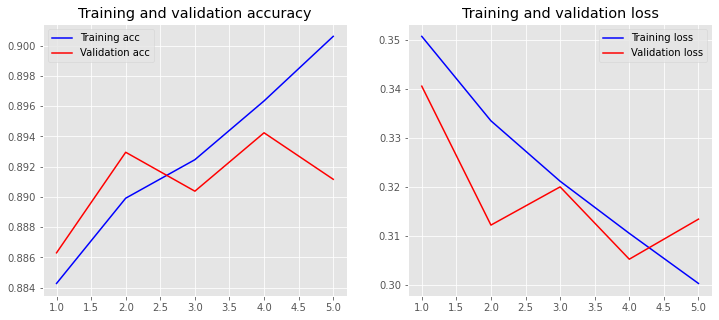

In [ ]:
plot_history(history)

# GPT


https://gmihaila.github.io/tutorial_notebooks/gpt2_finetune_classification/

https://colab.research.google.com/github/gmihaila/ml_things/blob/master/notebooks/pytorch/gpt2_finetune_classification.ipynb#scrollTo=6Svsqk7roQJ2

https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification

https://colab.research.google.com/drive/1cMjCtLVOElZUcdVCzTmQybdNOT1aXqNK?usp=sharing

https://huggingface.co/models?search=sberba




In [ ]:
!pip install transformers

In [ ]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer, 
    TFGPT2ForSequenceClassification, 
    GPT2ForSequenceClassification)

In [ ]:
model_path = 'sberbank-ai/rugpt3medium_based_on_gpt2'

model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_path, num_labels=7)
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
gpt_model = GPT2ForSequenceClassification.from_pretrained(model_path, config=model_config)
model = gpt_model

Some weights of the model checkpoint at sberbank-ai/rugpt3medium_based_on_gpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/rugpt3medium_based_on_gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# dialogrpt
# DialogRPT-updown
model_name = 'DialogRPT-updown'
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/'+ model_name)


In [ ]:
# TFGPT2ForSequenceClassification
# GPT2ForSequenceClassification
model = GPT2ForSequenceClassification.from_pretrained('microsoft/'+ model_name)

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)

In [ ]:
tokenizer.tokenize('hello')

['he', 'll', 'o']

In [ ]:
tokenizer('привет мир')

{'input_ids': [960, 577, 2309], 'attention_mask': [1, 1, 1]}

In [ ]:
sent = 'привет мир'
sent = 'Модель документа, основанная на анализе гиперссылок. Алгоритм PageRank(стандартная и модифицированная версии алгоритма)'
tokenizer.tokenize(sent)

In [ ]:
tokenizer("Hello, my dog is cute", return_tensors="pt")

{'input_ids': tensor([[   44, 42911,    16, 18841,   737,  2335,  1132,   591,  8196]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
import torch
torch.tensor([1]).unsqueeze(0)

tensor([[1]])

In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits
logits

tensor([[ 0.3278, -0.0235,  0.0786,  0.1613, -0.2044,  0.3672,  0.3805]],
       grad_fn=<IndexBackward>)

In [ ]:
inputs = []
n=5
for i in range(n):
  inputs.append(tokenizer(str(i), return_tensors="pt"))
inputs

[{'input_ids': tensor([[20]]), 'attention_mask': tensor([[1]])},
 {'input_ids': tensor([[21]]), 'attention_mask': tensor([[1]])},
 {'input_ids': tensor([[22]]), 'attention_mask': tensor([[1]])},
 {'input_ids': tensor([[23]]), 'attention_mask': tensor([[1]])},
 {'input_ids': tensor([[24]]), 'attention_mask': tensor([[1]])}]

In [ ]:
labels = torch.tensor(list(range(n))).unsqueeze(0)  # Batch size 1
labels

tensor([[0, 1, 2, 3, 4]])

In [ ]:
outputs = model(**inputs, labels=labels)


In [ ]:
tokenizer(str(i), return_tensors="pt")

{'input_ids': tensor([[24]]), 'attention_mask': tensor([[1]])}

In [ ]:
model

In [ ]:
logits

tensor([[ 0.2761,  1.5317, -0.6086,  0.2029,  0.1287,  0.2042, -0.1912]],
       grad_fn=<IndexBackward>)

In [ ]:
outputs

In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
inputs["labels"] = tf.reshape(tf.constant(1), (-1, 1)) # Batch size 1

outputs = model(**inputs)
loss = outputs.loss
logits = outputs.logits

In [ ]:
inputs

{'input_ids': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=
array([[   44, 42911,    16, 18841,   737,  2335,  1132,   591,  8196]],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>, 'labels': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>}

In [ ]:
# SparseCategoricalCrossentropy
model = gpt_model

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
# metric = tf.keras.metrics.SparseCategoricalCrossentropy('accuracy')# categorical_crossentropy accuracy
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

## classes creator

In [ ]:
# # Install transformers library.
# !pip install -q git+https://github.com/huggingface/transformers.git
# # Install helper functions.
# !pip install -q git+https://github.com/gmihaila/ml_things.git

In [ ]:
!pip install -q git+https://github.com/gmihaila/ml_things.git

In [ ]:
import io
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:

import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)


In [ ]:
set_seed(123)
epochs = 4
batch_size = 8
max_length = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'
labels_ids = dict(zip(list(main_tags_dict.keys()), list(main_tags_dict.keys())))
# labels_ids = {'neg': 0, 'pos': 1}
n_labels = len(labels_ids)
n_labels = len(main_tags_list)
n_labels

7

In [ ]:
tokenizer.padding_side = "left"
# tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})


model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

Model loaded to `cuda`


In [ ]:
class MovieReviewsDataset(Dataset):
  

  def __init__(self, data_text, data_label, use_tokenizer):

    self.texts = data_text
    self.labels = data_label
    self.n_examples = len(self.labels)
    return

  def __len__(self):
    return self.n_examples

  def __getitem__(self, item):
    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.

        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.

        labels = [self.labels_encoder[label] for label in labels]

        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [ ]:
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

# X_train_text = [d['text'] for d in data_train]
# X_test_text = [d['text'] for d in data_test]

# y_train = [d['label'] for d in data_train]
# y_test

train_dataset = MovieReviewsDataset(
    data_text=X_train_text[:1000],
    data_label=y_train[:1000], 
    use_tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)

In [ ]:
valid_dataset =  MovieReviewsDataset(
    data_text=X_test_text[:1000],
    data_label=y_test[:1000], 
    use_tokenizer=tokenizer)

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

In [ ]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
len(train_dataloader)

125

In [ ]:
X_train_text[0]

In [ ]:
for batch in tqdm(train_dataloader, total=len(train_dataloader)):
  # print('1')
  pass

In [ ]:
# # Create data collator to encode text and labels into numbers.
# gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
#                                                           labels_encoder=labels_ids, 
#                                                           max_sequence_len=max_length)


# print('Dealing with Train...')
# # Create pytorch dataset.
# train_dataset = MovieReviewsDataset(path='/content/aclImdb/train', 
#                                use_tokenizer=tokenizer)
# print('Created `train_dataset` with %d examples!'%len(train_dataset))

# # Move pytorch dataset into dataloader.
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
# print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

# print()

# print('Dealing with Validation...')
# # Create pytorch dataset.
# valid_dataset =  MovieReviewsDataset(path='/content/aclImdb/test', 
#                                use_tokenizer=tokenizer)
# print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# # Move pytorch dataset into dataloader.
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
# print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## train

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                  )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}


In [ ]:
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch



Training on batches...



Validation on batches...



  train_loss: 0.97896 - val_loss: 0.63950 - train_acc: 0.66300 - valid_acc: 0.80000


Training on batches...



Validation on batches...



  train_loss: 0.27903 - val_loss: 0.54420 - train_acc: 0.91100 - valid_acc: 0.84400


Training on batches...



Validation on batches...



  train_loss: 0.09011 - val_loss: 0.56103 - train_acc: 0.97400 - valid_acc: 0.86200


Training on batches...



Validation on batches...



  train_loss: 0.02301 - val_loss: 0.57138 - train_acc: 0.99100 - valid_acc: 0.86300




/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


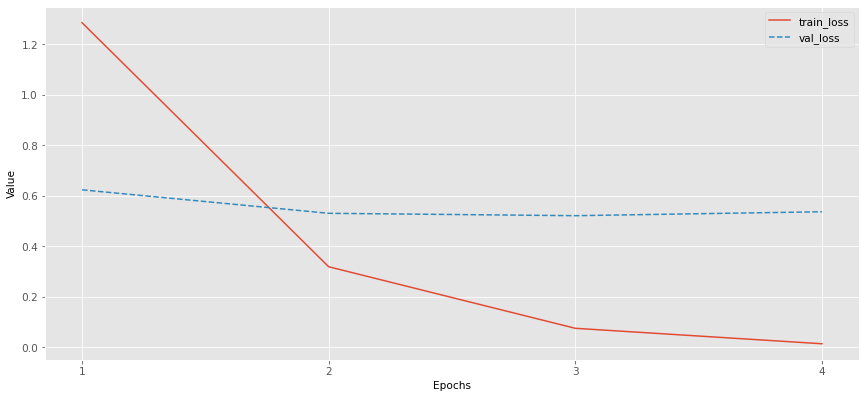

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


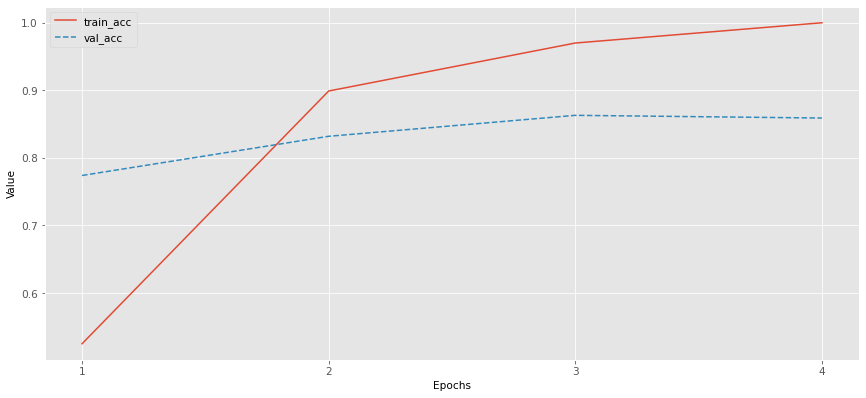

In [ ]:

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# bert pytorch


https://github.com/Samsung-IT-Academy/stepik-dl-nlp/blob/master/task9_bert_sentiment_analysis.ipynb
